# Installs & Imports

In [ ]:
!pip install -q ucimlrepo optuna

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import joblib
import pickle
import os
import sys

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor

import optuna

from ucimlrepo import fetch_ucirepo

# Loading the Data

In [ ]:
# Load the dataset
wine_ds = fetch_ucirepo(id=186)

In [ ]:
# Extract features and labels
X = wine_ds.data.features
y = wine_ds.data.targets

In [ ]:
# Create single DataFrame
df = pd.concat([X, y], axis=1)

In [ ]:
# Examine the DataFrame
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Preparing the Data

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Print the shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}\n")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (5197, 11)
y_train: (5197, 1)

X_test: (1300, 11)
y_test: (1300, 1)


# Pipeline Creation

In [ ]:
# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ExtraTreesRegressor(random_state=42))
])

In [ ]:
# Cross validation
scores = cross_validate(pipeline, X_train, y_train.values.ravel(), cv=5, scoring=['neg_mean_squared_error'])

# Calculate average performance across all cross-validation folds
mean_neg_mse = np.mean(scores['test_neg_mean_squared_error'])

# Convert negative MSE back to positive
mean_mse = -mean_neg_mse

# Print the result
print(f"Average MSE from 5-fold cross-validation: {mean_mse}")

Average MSE from 5-fold cross-validation: 0.36241756972310657


# Hyperparameter Tuning

In [ ]:
# Define objective function to minimize
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    min_weight_fraction_leaf = trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5)

    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42))
    ])

    # Perform 5-fold cross-validation
    scores = cross_validate(pipeline, X_train, y_train.values.ravel(), cv=5, scoring=['neg_mean_squared_error'])

    # Calculate the mean of the negative mean squared error scores
    mean_neg_mse = np.mean(scores['test_neg_mean_squared_error'])

    # Return the mean score
    return mean_neg_mse

In [ ]:
# Create Optuna study object
study = optuna.create_study(direction='maximize')

# Perform tuning
study.optimize(objective, n_trials=100)

# Print best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

# Print best score
print(f"Best score: {study.best_value}")

[I 2024-02-22 05:05:15,491] A new study created in memory with name: no-name-e539d030-602e-44be-a878-6fadb9a3ab48
[I 2024-02-22 05:05:31,454] Trial 0 finished with value: -0.6211687340515092 and parameters: {'n_estimators': 947, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.4787511636210957, 'min_weight_fraction_leaf': 0.07733156436634048}. Best is trial 0 with value: -0.6211687340515092.
[I 2024-02-22 05:05:51,859] Trial 1 finished with value: -0.45679388651359654 and parameters: {'n_estimators': 878, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 0.8247633541492868, 'min_weight_fraction_leaf': 0.43437312577681747}. Best is trial 1 with value: -0.45679388651359654.
[I 2024-02-22 05:06:00,947] Trial 2 finished with value: -0.5382032798601187 and parameters: {'n_estimators': 819, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 0.6300922436717408, 'min_weight_fraction_leaf': 0.104148831288

Best hyperparameters: {'n_estimators': 573, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.42491901478516425, 'min_weight_fraction_leaf': 0.43111621230282454}
Best score: -0.35415889882171714


In [ ]:
# Redefine and retrain
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ExtraTreesRegressor(**study.best_params, random_state=42))
])

best_pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=29,
                                     max_features=0.42491901478516425,
                                     min_weight_fraction_leaf=0.43111621230282454,
                                     n_estimators=573, random_state=42))])

# Model Evaluation

In [ ]:
# Evaluate the pipeline
predictions = best_pipeline.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MSE: 0.7302969680914035
RMSE: 0.8545741442914147
MAE: 0.6646044502955268
MAPE: 0.11897480216358286
R2: 0.01117028477926274


In [ ]:
# Create metrics DataFrame
metrics_df = pd.DataFrame(
    [mse, rmse, mae, mape, r2],
    index=['MSE', 'RMSE', 'MAE', 'MAPE', 'R2'],
    columns=['Value']
)
metrics_df

,Value
MSE,0.730297
RMSE,0.854574
MAE,0.664604
MAPE,0.118975
R2,0.011170


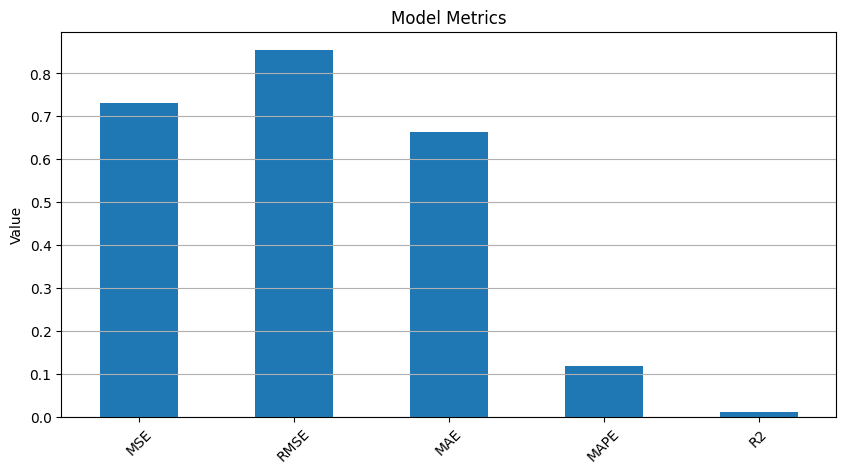

In [ ]:
# Plot metrics
metrics_df.plot(kind='bar', figsize=(10, 5), legend=False)
plt.title('Model Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
# Save the pipeline object
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)